# Visualize measures data

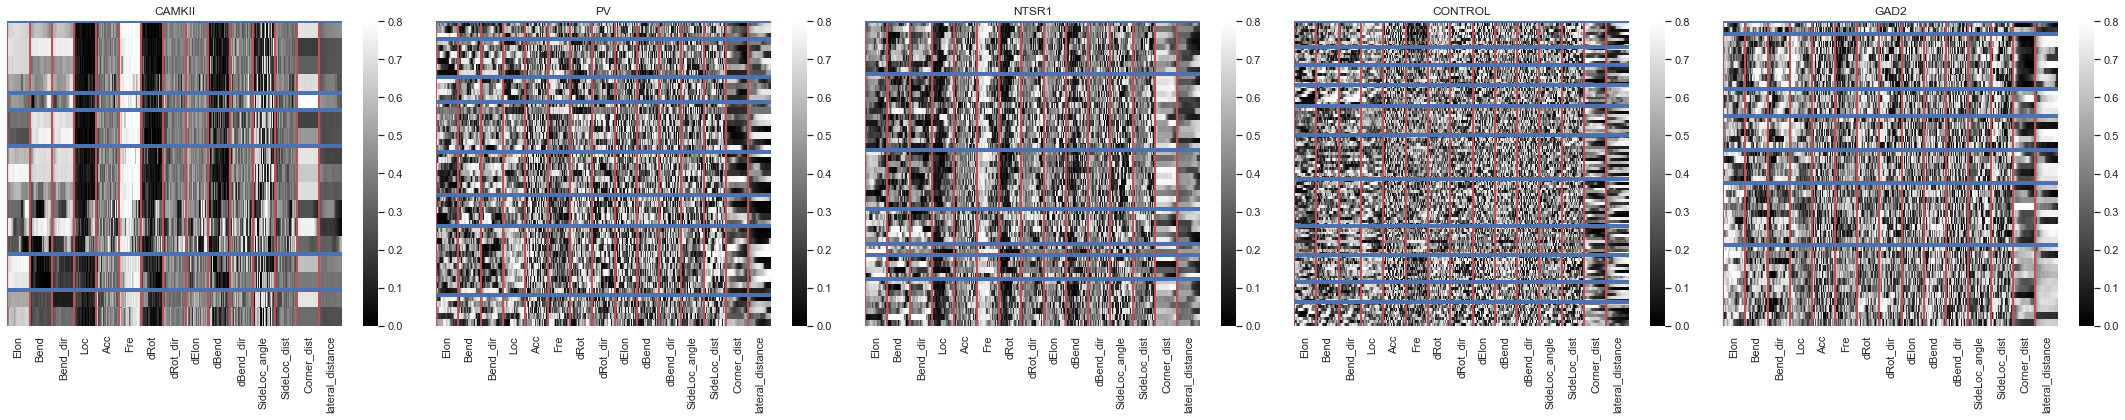

In [48]:
""" Heatmaps for each mouseline. """
# Only used for visualization of 
def _flatten_trial_measures(trial, measures, measures_time_windows, n):
    # Specifically used when different measures have different time_windows, otherwise, use utils.split_data_segments
    flat_trial =[]
    for measure in measures:
        flat_trial.append(trial['measures', measure].to_numpy()[:measures_time_windows.get(measure, n)])
    return np.expand_dims(np.concatenate(flat_trial), 0)

def _flatten_trials(trials, meta, n=150, measures=None, measures_time_windows=None):
    heatmap = []
    for trial in trials:
        if measures is not None:
            if measures_time_windows is not None:
                heatmap.append(_flatten_trial_measures(trial, measures, measures_time_windows, n=n))
            else:
                heatmap.append(utils.split_data_segments(trial['measures'][measures].to_numpy(), n=n))
        else:
            if measures_time_windows is not None:
                heatmap.append(_flatten_trial_measures(trial, measures_list, measures_time_windows, n=n))
            else:
                heatmap.append(utils.split_data_segments(trial['measures'].to_numpy(), n=n)) # Make it reorganize in the correct way!!

    return np.concatenate(heatmap, axis=0)


df_dict_trials_flat = apply_dict_fn(df_dict_trials_norm, _flatten_trials, n=time_window)
trials_heatmap, trials_heatmap_meta = flatten_dict_line(df_dict_trials_flat)

fig, axs = plt.subplots(1, 5, figsize=(30, 6))
for i, (line, heatmap) in enumerate(trials_heatmap.items()):
    sb.heatmap(heatmap, cmap='gray', ax=axs[i]) # cmap='vlag'
    axs[i].set_title(line)
    for j in range(num_measures):
        axs[i].axvline(j*time_window, c='r', linewidth=2)
        axs[i].set_xticks(ticks=[time_window*i+(time_window//2) for i in range(num_measures)])
        axs[i].set_xticklabels(labels=measures_labels, rotation=90)
        axs[i].set_yticks([])

for i, (line, meta_line) in enumerate(trials_heatmap_meta.items()):
    for (exp, sess), (start, stop) in meta_line.items():
        axs[i].axhline(start, c='b', linewidth=4)

plt.tight_layout()
plt.savefig(os.path.join(analysis_path, 'measures_heatmap.png'), dpi=200)

plt.show()

# Analysis trial data

### Clustering

In [51]:
""" Convert dict with list of trial dfs, to a list of flattened trials. (aka make the heatmap)"""

def get_trials_matrix(measures=None, indices=None, measures_time_windows=None):
    """ Returns a matrix where each row is a trial with the measures concatenated.
        measures: None if all measures are used, otherwise a list with the selected measure names
        indices: None if the full measures need to be used, otherwise only takes the values on the given indices"""
    df_dict_trials_subset_flat = apply_dict_fn(df_dict_trials_norm, _flatten_trials, measures=measures, n=time_window, measures_time_windows=measures_time_windows)
    trials_subset_heatmap, trials_subset_heatmap_meta = flatten_dict_all(df_dict_trials_subset_flat)
    if indices is not None:
        trials_subset_heatmap = trials_subset_heatmap[:,useful_feats]
        
    # Find out the mouselines for each trial
    trial_mouselines = np.empty(len(trials_subset_heatmap), dtype="S10")
    for line, meta_line in trials_subset_heatmap_meta.items():
        start = min(meta_line.values())[0]
        stop = max(meta_line.values())[1]
    #     line_trials[line] = (start, stop)
        trial_mouselines[start:stop] = line
    return trials_subset_heatmap, trials_subset_heatmap_meta, df_dict_trials_subset_flat, trial_mouselines
     
def lines_2_ints(trial_mouselines):
    tm_ints_lines, tm_ints = np.unique(trial_mouselines, return_inverse=True)
    return tm_ints, tm_ints_lines

In [52]:
""" Select subset of measures """
# clustering_measures = ['post_elongation', 'post_bend', 'mov_locomotion', 'mov_freeze', 'mov_locomotion_side_dist', 'corner_distance', 'lateral_distance']
# clustering_measures = ['post_elongation', 'mov_locomotion', 'mov_freeze', 'mov_locomotion_side_dist', 'corner_distance', 'lateral_distance']
# clustering_measures = ['post_elongation', 'mov_locomotion', 'mov_freeze', 'mov_rotation', 'mov_rotation_D', 'mov_locomotion_side_dist', 'corner_distance']
clustering_measures = ['post_elongation', 'mov_locomotion', 'mov_acceleration', 'mov_freeze', 'mov_rotation_D', 'mov_bend', 'mov_locomotion_side_dist', 'lateral_distance', 'corner_distance']
measures_time_windows = {'mov_acceleration': 30, 
                         'mov_freeze': 90, 
                         'mov_rotation_D':30, 
                         'mov_bend': 30, 
                         'mov_locomotion_side_dist': 30, 
                         'lateral_distance': 90, 
                         'corner_distance': 90}
# Constrain the trials to only contain information of the given clustering_measures

In [53]:
trials_matrix, trials_matrix_meta, trials_dict_flat, trial_mouselines = get_trials_matrix(clustering_measures, None, measures_time_windows)
# trials_matrix, trials_matrix_meta, trials_dict_flat, trial_mouselines = get_trials_matrix(None, useful_feats)
tm_ints, tm_ints_lines = lines_2_ints(trial_mouselines)


### Visualization

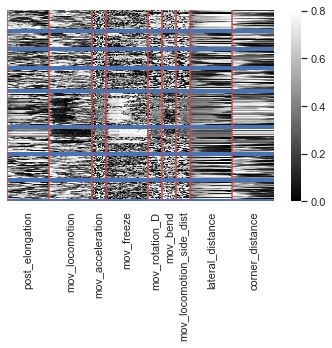

In [62]:
""" Clusters shown in heatmap. """
labels = kmeans.predict(X)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
heatmap_clusters = []
heatmap_mouselines = []
for cluster in range(n_clusters):
    heatmap_clusters.append(trials_matrix[labels==cluster])
    heatmap_mouselines.append(np.array(trial_mouselines)[labels==cluster])

combined_heatmap_clustered = np.vstack(heatmap_clusters)
sb.heatmap(combined_heatmap_clustered, cmap='gray', ax=ax) 
cluster_bounds = np.cumsum([len(heatmap_cluster) for heatmap_cluster in heatmap_clusters])
for bound in cluster_bounds:
    ax.axhline(bound, c='b', linewidth=4)

curr_idx = 0
x_ticks = []
for i, measure in enumerate(clustering_measures):
#     ax.axvline(time_window*i, c='r')
    ax.axvline(curr_idx, c='r')
    m_time = measures_time_windows.get(measure, time_window)
    x_ticks.append(curr_idx + (m_time//2))
    curr_idx += m_time
    

# ax.set_xticks(ticks=[time_window*i+(time_window//2) for i in range(len(clustering_measures))])
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels=clustering_measures, rotation=90)
ax.set_yticks([])

plt.tight_layout()
plt.savefig(os.path.join(cluster_save_path, 'clustering_heatmap.png'), dpi=100)
plt.show()